In [1]:
# Datenzugriff
from configs.path_manager import get_path
from db_models import *

# Utils
import src.utils.presenter as show
from src.utils.initialization import jobs_jssp_init as init

# neue Utils!
import src.utils.visualization.analyze_deadline_generator as analyze
from src.utils.initialization.gen_deadlines import get_temporary_df_times_from_schedule, add_groupwise_lognormal_deadlines_by_group_mean, improve_created_deadlines

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.min_rows', 15)
pd.set_option('display.max_rows', 21)

### Routings

In [2]:
db.connect(reuse_if_open=True)

# Routing-Einträge abfragen
query = RoutingOperation.select()

records = [{
    "Routing_ID": r.routing.id,
    "Operation": r.operation,
    "Machine": r.machine,
    "Processing Time": r.duration
} for r in query]

db.close()
df_routings = pd.DataFrame(records)
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
6,0,6,M06,62
...,...,...,...,...
93,9,3,M06,7
94,9,4,M08,64


In [3]:
day_count = 360

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = day_count, shift_length = 1440,
                                                        u_b_mmax = 0.9, shuffle = True
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,79,1440
1,J25-0001,6,129,1440
2,J25-0002,0,198,1440
3,J25-0003,2,243,1440
4,J25-0004,3,287,1440
5,J25-0005,1,498,1440
6,J25-0006,9,790,1440
...,...,...,...,...
7243,J25-7243,5,518075,518400
7244,J25-7244,3,518085,518400


In [4]:
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
6,J25-0000,8,6,M06,40
...,...,...,...,...,...
72493,J25-7249,4,3,M05,61
72494,J25-7249,4,4,M03,26


## I. Simulation

In [5]:
df_problem = df_jssp.merge(
    df_jobs_arrivals[['Job', 'Routing_ID','Arrival', 'Ready Time']],
    on=['Job', 'Routing_ID'],
    how='left'
)
df_problem

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time
0,J25-0000,8,0,M00,76,79,1440
1,J25-0000,8,1,M01,69,79,1440
2,J25-0000,8,2,M03,76,79,1440
3,J25-0000,8,3,M05,51,79,1440
4,J25-0000,8,4,M02,85,79,1440
5,J25-0000,8,5,M09,11,79,1440
6,J25-0000,8,6,M06,40,79,1440
...,...,...,...,...,...,...,...
72493,J25-7249,4,3,M05,61,518302,518400
72494,J25-7249,4,4,M03,26,518302,518400


In [6]:
simulation = ProductionSimulation(earliest_start_column = "Ready Time", sigma = 0, verbose = False)
simulation.run(df_problem, start_time = 0, end_time = None)

In [7]:
df_fcfs_execution = simulation.get_finished_operations_df()
df_fcfs_execution

,Job,Routing_ID,Ready Time,Arrival,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,1440,79,0,M00,1440.0,76.0,1516.0
1,J25-0000,8,1440,79,1,M01,1915.0,69.0,1984.0
2,J25-0000,8,1440,79,2,M03,2017.0,76.0,2093.0
3,J25-0000,8,1440,79,3,M05,2093.0,51.0,2144.0
4,J25-0000,8,1440,79,4,M02,2277.0,85.0,2362.0
5,J25-0000,8,1440,79,5,M09,2362.0,11.0,2373.0
6,J25-0000,8,1440,79,6,M06,2373.0,40.0,2413.0
...,...,...,...,...,...,...,...,...,...
72493,J25-7249,4,518400,518302,3,M05,519533.0,61.0,519594.0
72494,J25-7249,4,518400,518302,4,M03,519877.0,26.0,519903.0


In [8]:
if day_count <= 5:
    show.plot_gantt(df_fcfs_execution, perspective="Machine")

In [9]:
df_jobs_times_temp = get_temporary_df_times_from_schedule(df_fcfs_execution, df_jssp)
df_jobs_times_temp

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time
0,J25-0000,8,79,1440,2704.0,597
1,J25-0001,6,129,1440,2336.0,416
2,J25-0002,0,198,1440,2925.0,395
3,J25-0003,2,243,1440,2801.0,568
4,J25-0004,3,287,1440,2697.0,655
5,J25-0005,1,498,1440,2630.0,510
6,J25-0006,9,790,1440,2905.0,540
...,...,...,...,...,...,...
7243,J25-7243,5,518075,518400,520377.0,496
7244,J25-7244,3,518085,518400,520251.0,655


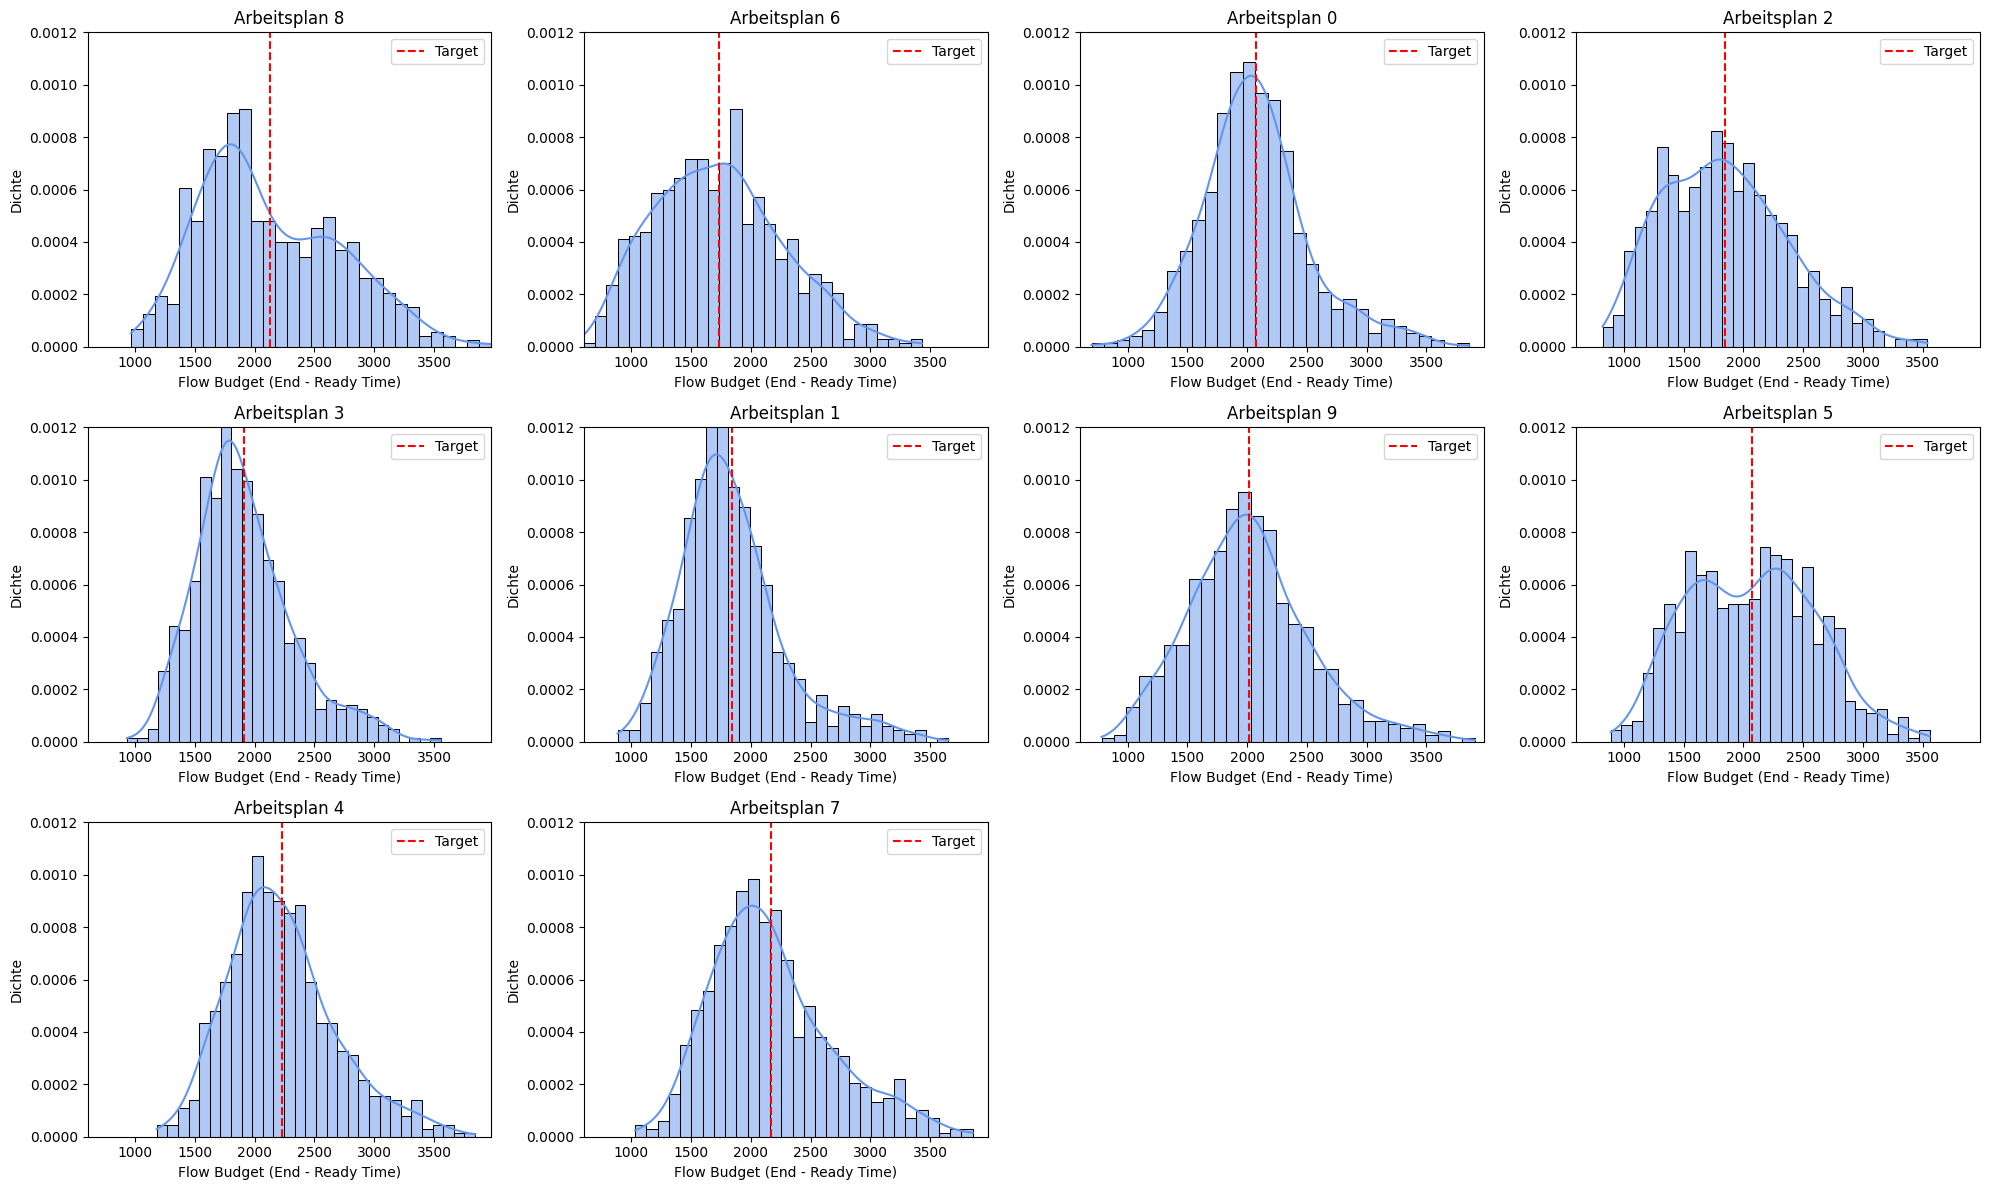

In [10]:
fig = analyze.plotfig_empirical_flow_budget_distributions(df_jobs_times_temp, deadline_column = 'End', y_max = 0.0012)
plt.show()

## II. Log-Normalverteilung

In [11]:
df_times = add_groupwise_lognormal_deadlines_by_group_mean(df_jobs_times_temp, sigma=0.3)
df_times

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660.0
1,J25-0001,6,129,1440,2336.0,416,2338.0
2,J25-0002,0,198,1440,2925.0,395,3744.0
3,J25-0003,2,243,1440,2801.0,568,3379.0
4,J25-0004,3,287,1440,2697.0,655,4856.0
5,J25-0005,1,498,1440,2630.0,510,3106.0
6,J25-0006,9,790,1440,2905.0,540,3539.0
...,...,...,...,...,...,...,...
7243,J25-7243,5,518075,518400,520377.0,496,520072.0
7244,J25-7244,3,518085,518400,520251.0,655,520389.0


## III. Plot der Verteilung

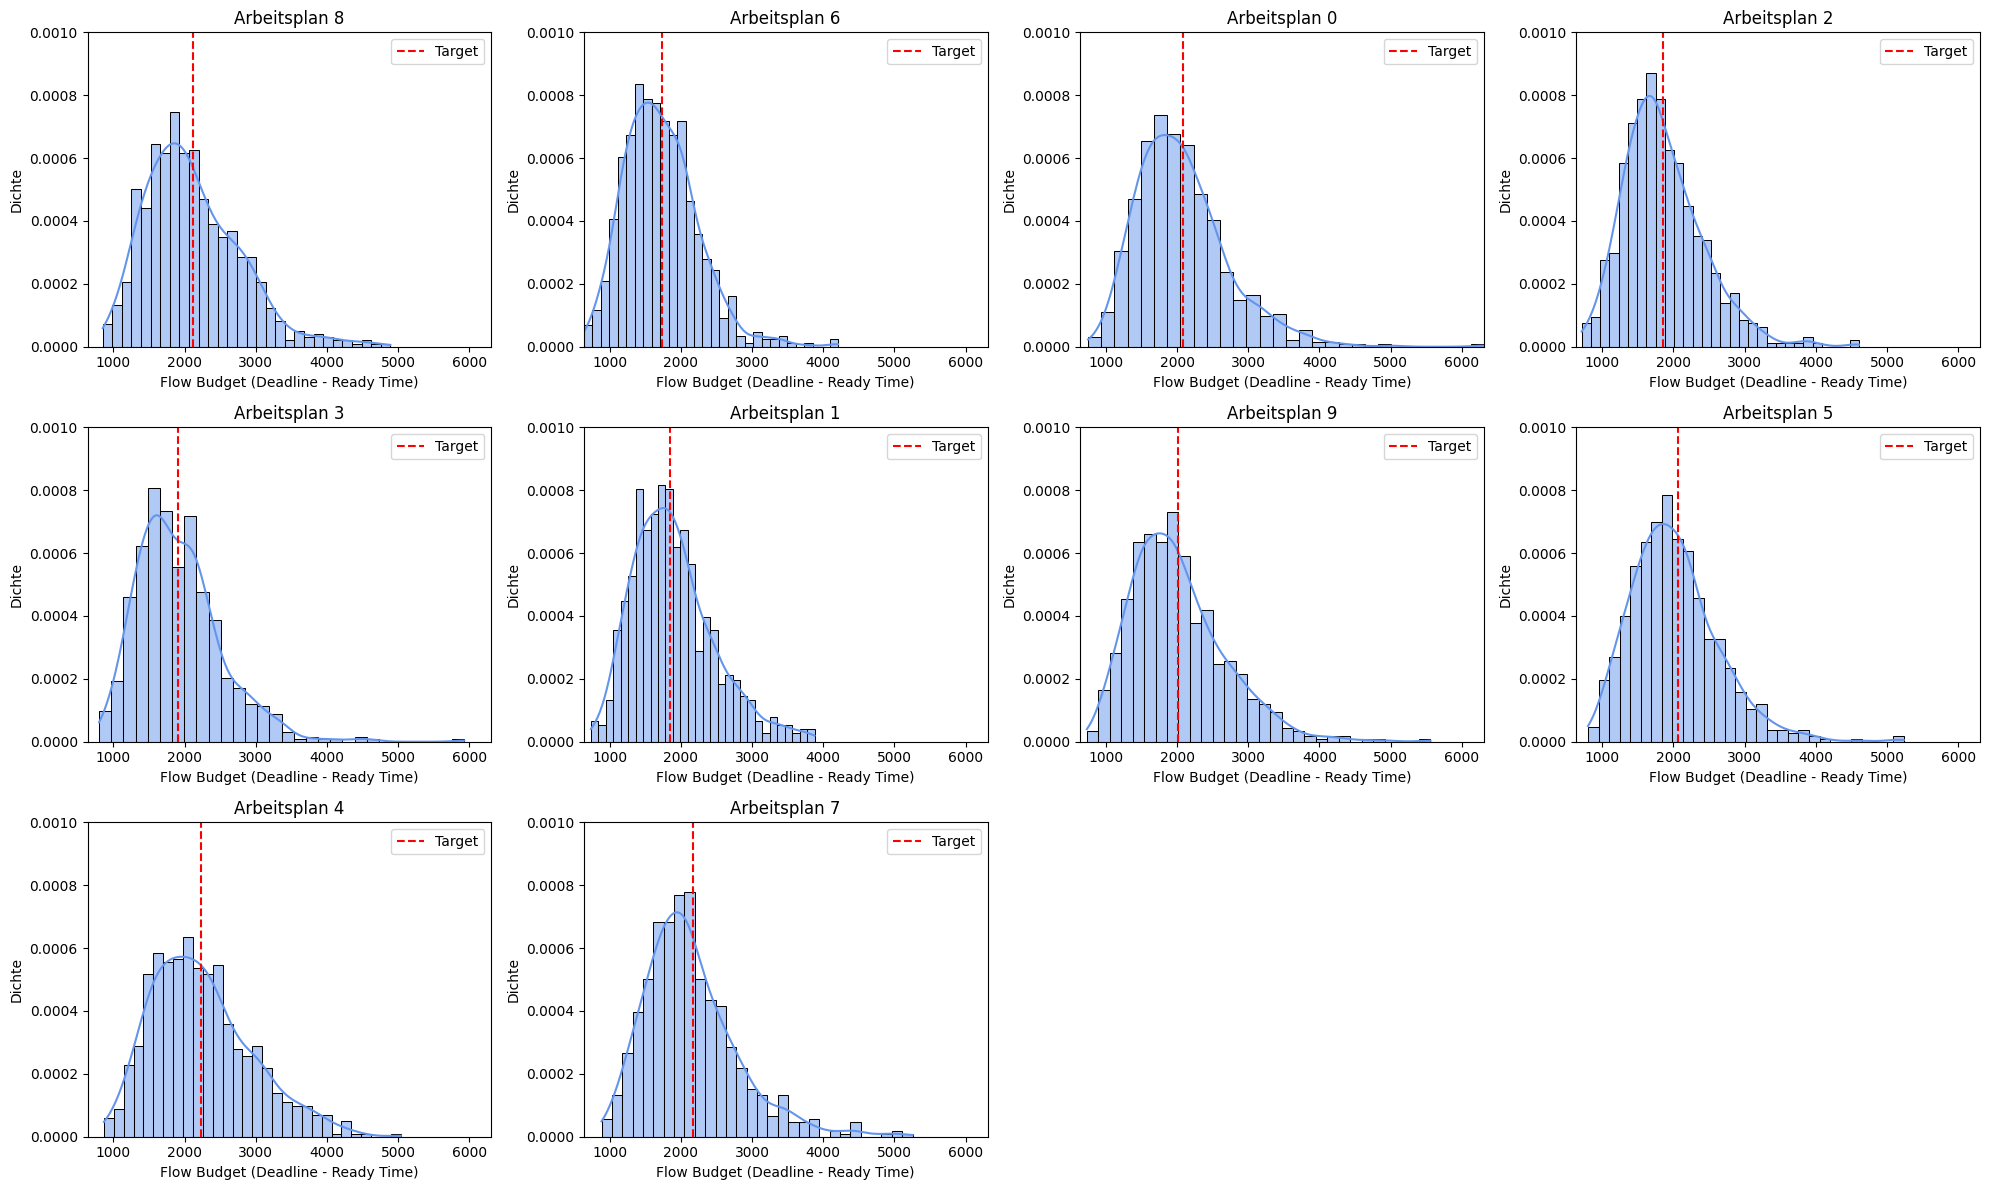

In [12]:
fig = analyze.plotfig_empirical_flow_budget_distributions(df_times)
plt.show()

## IV) "Untere Begrenzung" der Deadlines

In [13]:
# mind. 75 % jeder Bearbeitungszeit ist garantiert innerhalb der Deadline (theoretisch) erreichbar
# Deadline = min. 'Ready Time' + 'Processing Time' * 75 % oder die zuvor generierte Deadline
df_times = improve_created_deadlines(df_times, min_covered_proc_times_percentage = 0.75)
df_times

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
...,...,...,...,...,...,...,...
7243,J25-7243,5,518075,518400,520377.0,496,520072
7244,J25-7244,3,518085,518400,520251.0,655,520389


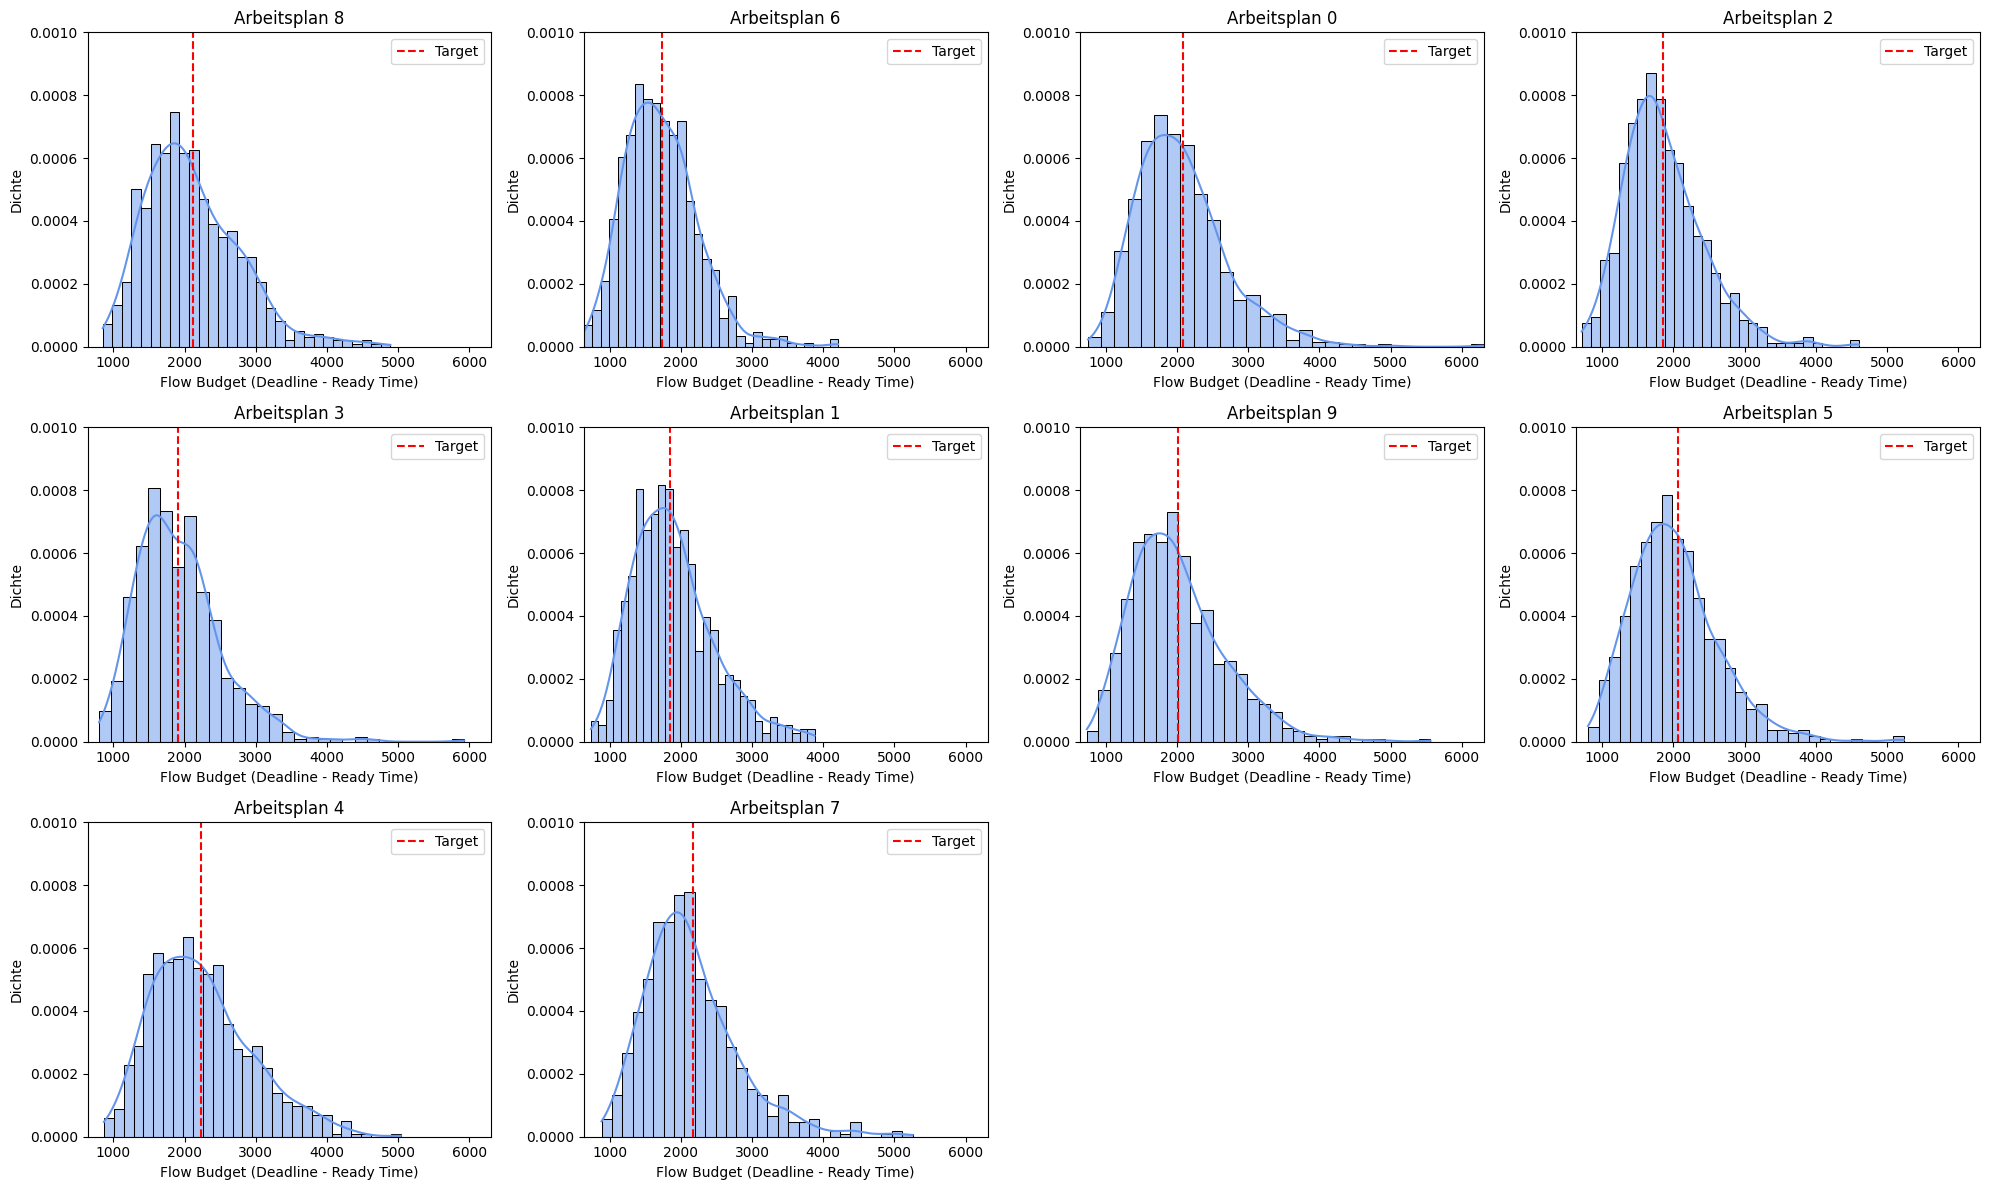

In [14]:
fig = analyze.plotfig_empirical_flow_budget_distributions(df_times)
plt.show()

### Export

In [15]:
# Job.add_jobs_from_dataframe(df_times, version="base", due_date_column='Deadline')

In [16]:
basic_data_path = get_path("data", "basic")
df_times.to_csv(basic_data_path / f"jobs_times_final.csv", index = False)
df_jssp.to_csv(basic_data_path / f"jssp_final.csv", index = False)